In [1]:
import tensorflow as tf
import numpy as np
from MNIST import load_mnist
#from MNISTSegmentation import DataSeg
import matplotlib.pyplot as plt
from skimage import io
%matplotlib inline

In [2]:
MNIST_DIR = 'D:/Documents/NN/MNIST/data/'
TRAIN_FILES = ['train-images.idx3-ubyte','train-labels.idx1-ubyte']
TEST_FILES = ['t10k-images.idx3-ubyte','t10k-labels.idx1-ubyte']

In [112]:
class Data:
    """
    It will store our data. We can retreive 4 types of data: image, label, 
        segmentation, and onehot key segmentation data.
    The method to retreive information is through next_batch, since onehot data
        cannot be generated all at once due to memory constrains.
    """
    def __init__(self,im_path,lb_path,validation=False):
        self.ims = load_mnist(im_path)
        self.__h = self.ims.shape[1]
        self.__w = self.ims.shape[2]
        self.ims = self.ims.reshape(-1,(self.__h*self.__w))
        
        self.lbs = load_mnist(lb_path)
        self.lbs = self.lbs.reshape(-1,1)
        self.seg = self.create_seg_data()
        
        #self.onehotenc = self.create_onehot()
        
        # Reshape to let the images as 28 by 28
        self.ims = self.ims.reshape(-1,self.__h,self.__w)
        self.seg = self.seg.reshape(-1,self.__h,self.__w)
        
        self.batch = 0
        
        # Enables this data if validation is True
        self.__validation = validation
        if self.__validation:
            self.val_init = self.lbs.shape[0]-int(self.lbs.shape[0]*0.1)
            self.batch_val = self.val_init
        
    def create_seg_data(self):
        """
        -Returns the segmentations of the data.
        -Zero represents background, 1 represent class 0
            2 represents class 1, and so on
        """
        seg1 = (self.ims==0)*-1
        seg2 = (self.ims!=0)*self.lbs
        seg = seg1 + seg2
        seg += 1
        return(seg)
    
    def create_onehot(self,init,end):
        """
        -Returns the database as onehot encoded image
        """
        num_cls = 11
        num_lbs = end-init
        
        tmp = self.seg[init:end]
        
        onehot = np.zeros((num_lbs,self.__h,self.__w,num_cls))
        
        for i in range(num_lbs):
            onehot[i,:,:,self.lbs[init:end][i]] = (tmp[i]!=0)*1
        
        return(onehot)
    
    def next_batch(self,increment):
        """
        -Returns a dictionary with the next batch requested
        -OneHot data is generated on the fly... not enough memory to do it all
        """
        end_batch = self.batch+increment
        ep = False
        if self.__validation:
            if end_batch>self.lbs.shape[0]-self.val_init:
                self.batch = 0
                end_batch = self.batch+increment
                ep = True
        else:
            if end_batch>self.lbs.shape[0]:
                self.batch = 0
                end_batch = self.batch+increment
        
        ims = self.ims[self.batch:end_batch]
        lbs = self.lbs[self.batch:end_batch]
        seg = self.seg[self.batch:end_batch]
        onehot = self.create_onehot(self.batch,end_batch)
        
        self.batch = end_batch
        batch = {'ims': ims, 'lbs': lbs, 'seg': seg, 'onehot': onehot,
                'new_ep': ep}
        
        return(batch)
    
    def next_batch_val(self,increment):
        """
        ep: indicates if a new epoch as started"""
        ep = False
        if self.__validation:
            end_batch = self.batch_val+increment
            if end_batch>self.lbs.shape[0]:
                self.batch_val = self.val_init
                end_batch = self.batch_val+increment
                ep = True

            ims = self.ims[self.batch_val:end_batch]
            lbs = self.lbs[self.batch_val:end_batch]
            seg = self.seg[self.batch_val:end_batch]
            onehot = self.create_onehot(self.batch_val,end_batch)

            self.batch_val = end_batch
            batch = {'ims': ims, 'lbs': lbs, 'seg': seg, 'onehot': onehot,
                    'new_ep': ep}
            
            return(batch)
        else:
            print('No validation data!')

In [113]:
train_data = Data(MNIST_DIR+TRAIN_FILES[0],MNIST_DIR+TRAIN_FILES[1],validation=True)
test_data = Data(MNIST_DIR+TEST_FILES[0],MNIST_DIR+TEST_FILES[1])

# Testing batch generation
tmp = train_data.next_batch(5)
tmp2 = train_data.next_batch_val(5)

print(train_data.ims.shape)
print(train_data.seg.shape)

(60000, 28, 28)
(60000, 28, 28)


[[5]
 [3]
 [5]
 [0]
 [0]]
False
[[5]
 [0]
 [4]
 [1]
 [9]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0

C:\Users\hecto\AppData\Local\conda\conda\envs\compvi\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


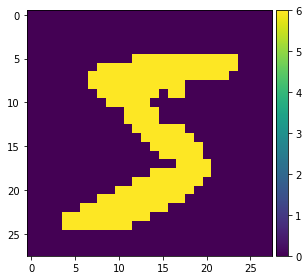

In [114]:
print(tmp2['lbs'])
print(tmp['new_ep'])
print(tmp['lbs'])
print(tmp['onehot'][0,:,:,5].astype(int))
print(tmp['seg'][0])
io.imshow(tmp['seg'][0])

In [124]:
class MnistSeg:
    def __init__(self,train_data,test_data):
        self.train_data = train_data
        self.test_data = test_data
        
        # TODO: Make it dynamic...
        self.im_h = 28
        self.im_w = 28
        self.im_chan = 1
        self.num_class = 11
        
        self.x = tf.placeholder(tf.float32,
                                shape=[None,self.im_h,self.im_w,self.im_chan],
                                name='x')
        self.y_onehot = tf.placeholder(tf.float32,
                                shape=[None,self.im_h,self.im_w,11],
                                name='y_onehot')
        self.y_seg = tf.placeholder(tf.float32,
                                shape=[None,self.im_h,self.im_w,1],
                                name='y_seg')
        self.model = self.__model()
    
    def __model(self):
        c1_shape = [3,3,1,16]
        self.conv1 = self.__conv(inp=self.x,shape=c1_shape,relu=True)
        
        c2_shape = [3,3,16,16]
        self.conv2 = self.__conv(inp=self.conv1,shape=c2_shape,relu=True)
        
        #### [?,28,28,16]
        c3_shape = [3,3,16,32]
        self.conv3 = self.__conv(inp=self.conv2,shape=c3_shape,
                                strides=[1,2,2,1],relu=True)
        
        c4_shape = [3,3,32,32]
        self.conv4 = self.__conv(inp=self.conv3,shape=c4_shape,relu=True)
        
        c5_shape = [3,3,32,32]
        self.conv5 = self.__conv(inp=self.conv4,shape=c5_shape,relu=True)
        
        #### [?,14,14,32]
        c6_shape = [3,3,32,64]
        self.conv6 = self.__conv(inp=self.conv5,shape=c6_shape,
                                strides=[1,2,2,1],relu=True)
        
        c7_shape = [3,3,64,64]
        self.conv7 = self.__conv(inp=self.conv6,shape=c7_shape,relu=True)
        
        c8_shape = [3,3,64,64]
        self.conv8 = self.__conv(inp=self.conv7,shape=c8_shape,relu=True)
        
        ######## [?,7,7,64]
        
        self.conv8_rs = tf.reshape(self.conv8,
                                   shape=[-1,7*7*64])
        
        self.fully1 = self.__fc(inp=self.conv8_rs,
                         shape=[7*7*64,7*7*64], relu=True)
        self.fully2 = self.__fc(inp=self.fully1,
                         shape=[7*7*64,7*7*64], relu=True)
        
        ######## [?,3136]
        
        self.fully2_rs = tf.reshape(self.fully2, shape=[-1,7,7,64])
        
        d1_shape = [3,3,64,64]
        self.deconv1 = self.__deconv(inp=self.fully2_rs,
                                     out_like=self.conv7,
                                     shape=d1_shape,strides=[1,1,1,1],
                                     relu=True)
        
        d2_shape = [3,3,64,64]
        self.deconv2 = self.__deconv(inp=self.deconv1,
                                     out_like=self.conv6,
                                     shape=d2_shape,strides=[1,1,1,1],
                                     relu=True)
        
        d3_shape = [3,3,32,64]
        self.deconv3 = self.__deconv(inp=self.deconv2,
                                     out_like=self.conv5,
                                     shape=d3_shape,strides=[1,2,2,1],
                                     relu=True)
        
        #### [?,14,14,32]
        
        d4_shape = [3,3,32,32]
        self.deconv4 = self.__deconv(inp=self.deconv3,
                                     out_like=self.conv4,
                                     shape=d4_shape,strides=[1,1,1,1],
                                     relu=True)
        
        d5_shape = [3,3,32,32]
        self.deconv5 = self.__deconv(inp=self.deconv4,
                                     out_like=self.conv3,
                                     shape=d5_shape,strides=[1,1,1,1],
                                     relu=True)
        
        d6_shape = [3,3,16,32]
        self.deconv6 = self.__deconv(inp=self.deconv5,
                                     out_like=self.conv2,
                                     shape=d6_shape,strides=[1,2,2,1],
                                     relu=True)
        
        #### [?,28,28,16]
        
        d7_shape = [3,3,16,16]
        self.deconv7 = self.__deconv(inp=self.deconv6,
                                     out_like=self.conv1,
                                     shape=d7_shape,strides=[1,1,1,1],
                                     relu=True)
        
        d8_shape = [3,3,11,16]
        tmp_x = tf.placeholder(tf.float32,shape=[5,28,28,11])
        self.deconv8 = self.__deconv(inp=self.deconv7,
                                     out_like=tmp_x,
                                     shape=d8_shape,strides=[1,1,1,1],
                                     relu=True)
        
        #### [?,28,28,11]
        self.scores = tf.nn.softmax(self.deconv8)
        self.y_pred = tf.argmax(input=self.scores, axis=3)
        
    def __weights(self,shape):
        """
        shape: [ker_h,ker_w,im_chan,num_ker]
        """
        w = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
        return(w)
    
    def __biases(self,shape):
        """
        shape: [num_ker]
        """
        b = tf.Variable(tf.constant(0.05,shape=shape))
        return(b)
    
    def __conv(self,inp,shape,strides=[1,1,1,1],padding='SAME',relu=False):
        """
        inp: input
        shape: [ker_h,ker_w,im_chan,num_ker]
        """
        w = self.__weights(shape)
        b = self.__biases([shape[3]])
        
        conv = tf.nn.conv2d(input=inp,
                           filter=w,
                           strides=strides,
                           padding=padding)
        
        conv += b
        
        if relu:
            conv = tf.nn.relu(conv)
        
        return(conv)
    
    def __fc(self,inp,shape,relu=False):
        """
        inp: input
        shape: [num_dim,num_class]
        """
        w = self.__weights(shape)
        b = self.__biases([shape[1]])
        
        fc = tf.matmul(inp,w)
        fc += b
        
        if relu:
            fc = tf.nn.relu(fc)
        
        return(fc)
    
    def __deconv(self,inp,out_like,shape,strides,padding='SAME',relu=False):
        """
        inp: input tensor
        out_like: ouput-like-shape tensro. What are the output
            tensor dimensions according to an existing tensor
        strides: strides used in out_like in the convolution
        shape: [ker_h,ker_w,out_C,in_c]
        """
        w = self.__weights(shape)
        b = self.__biases([shape[2]])
        out_shape = tf.shape(out_like)
        
        transpose_conv = tf.nn.conv2d_transpose(value=inp,
                                               filter=w,
                                               output_shape=out_shape,
                                               strides=strides,
                                               padding=padding)
        
        transpose_conv += b
        print(transpose_conv.get_shape())
        if relu:
            transpose_conv = tf.nn.relu(transpose_conv)
        
        return(transpose_conv)
    
    def loss(self,feed_dict):
        y_pred = self.y_pred.eval(feed_dict)
    
    def train(self,bs=5,epochs=1):
        with tf.Session() as sess:
            tf.global_variables_initializer().run()
            epoch = 1
            it = 1
            while True:
                data = self.train_data.next_batch(bs)
                feed_dict = {self.x: data['ims'].reshape(-1,28,28,1), 
                             self.y_seg: data['seg'].reshape(-1,28,28,11)}
                if data['new_ep']:
                    epoch += 1
                if epoch>epochs:
                    break
                    
                print('##### Epoch: %d Iter: %d'%(epoch,it))
                
                self.loss(feed_dict)
                
                it += 1
    
    def predict(self,input_data):
        feed_dict = {self.x: input_data}
        with tf.Session() as sess:
            # Used to initialize all variables
            tf.global_variables_initializer().run()
            output = self.scores.eval(feed_dict)
        
        return(output)

In [125]:
mnist = MnistSeg(train_data,test_data)
tmp_data = tmp['ims'].reshape(-1,28,28,1)
output = mnist.predict(tmp_data)
print(output.shape)

(?, ?, ?, 64)
(?, ?, ?, 64)
(?, ?, ?, 32)
(?, ?, ?, 32)
(?, ?, ?, 32)
(?, ?, ?, 16)
(?, ?, ?, 16)
(5, 28, 28, 11)
(5, 28, 28, 11)


C:\Users\hecto\AppData\Local\conda\conda\envs\compvi\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


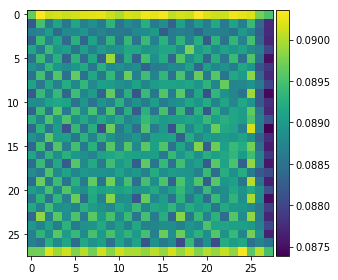

In [95]:
ind = 2
io.imshow(output[ind,:,:,0].reshape(28,28))
#print(output[ind].reshape(28,28))

In [123]:
mnist.train()

##### Epoch: 1 Iter: 1
##### Epoch: 1 Iter: 2
##### Epoch: 1 Iter: 3
##### Epoch: 1 Iter: 4
##### Epoch: 1 Iter: 5
##### Epoch: 1 Iter: 6
##### Epoch: 1 Iter: 7
##### Epoch: 1 Iter: 8
##### Epoch: 1 Iter: 9
##### Epoch: 1 Iter: 10
##### Epoch: 1 Iter: 11
##### Epoch: 1 Iter: 12
##### Epoch: 1 Iter: 13
##### Epoch: 1 Iter: 14
##### Epoch: 1 Iter: 15
##### Epoch: 1 Iter: 16
##### Epoch: 1 Iter: 17
##### Epoch: 1 Iter: 18
##### Epoch: 1 Iter: 19
##### Epoch: 1 Iter: 20
##### Epoch: 1 Iter: 21
##### Epoch: 1 Iter: 22
##### Epoch: 1 Iter: 23
##### Epoch: 1 Iter: 24
##### Epoch: 1 Iter: 25
##### Epoch: 1 Iter: 26
##### Epoch: 1 Iter: 27
##### Epoch: 1 Iter: 28
##### Epoch: 1 Iter: 29
##### Epoch: 1 Iter: 30
##### Epoch: 1 Iter: 31
##### Epoch: 1 Iter: 32
##### Epoch: 1 Iter: 33
##### Epoch: 1 Iter: 34
##### Epoch: 1 Iter: 35
##### Epoch: 1 Iter: 36
##### Epoch: 1 Iter: 37
##### Epoch: 1 Iter: 38
##### Epoch: 1 Iter: 39
##### Epoch: 1 Iter: 40
##### Epoch: 1 Iter: 41
##### Epoch: 1 Iter: 42
#

##### Epoch: 1 Iter: 336
##### Epoch: 1 Iter: 337
##### Epoch: 1 Iter: 338
##### Epoch: 1 Iter: 339
##### Epoch: 1 Iter: 340
##### Epoch: 1 Iter: 341
##### Epoch: 1 Iter: 342
##### Epoch: 1 Iter: 343
##### Epoch: 1 Iter: 344
##### Epoch: 1 Iter: 345
##### Epoch: 1 Iter: 346
##### Epoch: 1 Iter: 347
##### Epoch: 1 Iter: 348
##### Epoch: 1 Iter: 349
##### Epoch: 1 Iter: 350
##### Epoch: 1 Iter: 351
##### Epoch: 1 Iter: 352
##### Epoch: 1 Iter: 353
##### Epoch: 1 Iter: 354
##### Epoch: 1 Iter: 355
##### Epoch: 1 Iter: 356
##### Epoch: 1 Iter: 357
##### Epoch: 1 Iter: 358
##### Epoch: 1 Iter: 359
##### Epoch: 1 Iter: 360
##### Epoch: 1 Iter: 361
##### Epoch: 1 Iter: 362
##### Epoch: 1 Iter: 363
##### Epoch: 1 Iter: 364
##### Epoch: 1 Iter: 365
##### Epoch: 1 Iter: 366
##### Epoch: 1 Iter: 367
##### Epoch: 1 Iter: 368
##### Epoch: 1 Iter: 369
##### Epoch: 1 Iter: 370
##### Epoch: 1 Iter: 371
##### Epoch: 1 Iter: 372
##### Epoch: 1 Iter: 373
##### Epoch: 1 Iter: 374
##### Epoch: 1 Iter: 375


##### Epoch: 1 Iter: 668
##### Epoch: 1 Iter: 669
##### Epoch: 1 Iter: 670
##### Epoch: 1 Iter: 671
##### Epoch: 1 Iter: 672
##### Epoch: 1 Iter: 673
##### Epoch: 1 Iter: 674
##### Epoch: 1 Iter: 675
##### Epoch: 1 Iter: 676
##### Epoch: 1 Iter: 677
##### Epoch: 1 Iter: 678
##### Epoch: 1 Iter: 679
##### Epoch: 1 Iter: 680
##### Epoch: 1 Iter: 681
##### Epoch: 1 Iter: 682
##### Epoch: 1 Iter: 683
##### Epoch: 1 Iter: 684
##### Epoch: 1 Iter: 685
##### Epoch: 1 Iter: 686
##### Epoch: 1 Iter: 687
##### Epoch: 1 Iter: 688
##### Epoch: 1 Iter: 689
##### Epoch: 1 Iter: 690
##### Epoch: 1 Iter: 691
##### Epoch: 1 Iter: 692
##### Epoch: 1 Iter: 693
##### Epoch: 1 Iter: 694
##### Epoch: 1 Iter: 695
##### Epoch: 1 Iter: 696
##### Epoch: 1 Iter: 697
##### Epoch: 1 Iter: 698
##### Epoch: 1 Iter: 699
##### Epoch: 1 Iter: 700
##### Epoch: 1 Iter: 701
##### Epoch: 1 Iter: 702
##### Epoch: 1 Iter: 703
##### Epoch: 1 Iter: 704
##### Epoch: 1 Iter: 705
##### Epoch: 1 Iter: 706
##### Epoch: 1 Iter: 707


##### Epoch: 1 Iter: 997
##### Epoch: 1 Iter: 998
##### Epoch: 1 Iter: 999
##### Epoch: 1 Iter: 1000
##### Epoch: 1 Iter: 1001
##### Epoch: 1 Iter: 1002
##### Epoch: 1 Iter: 1003
##### Epoch: 1 Iter: 1004
##### Epoch: 1 Iter: 1005
##### Epoch: 1 Iter: 1006
##### Epoch: 1 Iter: 1007
##### Epoch: 1 Iter: 1008
##### Epoch: 1 Iter: 1009
##### Epoch: 1 Iter: 1010
##### Epoch: 1 Iter: 1011
##### Epoch: 1 Iter: 1012
##### Epoch: 1 Iter: 1013
##### Epoch: 1 Iter: 1014
##### Epoch: 1 Iter: 1015
##### Epoch: 1 Iter: 1016
##### Epoch: 1 Iter: 1017
##### Epoch: 1 Iter: 1018
##### Epoch: 1 Iter: 1019
##### Epoch: 1 Iter: 1020
##### Epoch: 1 Iter: 1021
##### Epoch: 1 Iter: 1022
##### Epoch: 1 Iter: 1023
##### Epoch: 1 Iter: 1024
##### Epoch: 1 Iter: 1025
##### Epoch: 1 Iter: 1026
##### Epoch: 1 Iter: 1027
##### Epoch: 1 Iter: 1028
##### Epoch: 1 Iter: 1029
##### Epoch: 1 Iter: 1030
##### Epoch: 1 Iter: 1031
##### Epoch: 1 Iter: 1032
##### Epoch: 1 Iter: 1033
##### Epoch: 1 Iter: 1034
##### Epoch: 1 

KeyboardInterrupt: 